In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/main-new-artifact-details/Artifact Description_new.csv
/kaggle/input/correct-mirror/Screenshot 2024-11-25 164651.png
/kaggle/input/wrong-mirror/Screenshot 2024-11-25 164447.png
/kaggle/input/flying-sheep/Screenshot 2024-11-25 150625.png
/kaggle/input/artifact-interiit/Artifact_Description.csv
/kaggle/input/pegasus/Screenshot 2024-11-24 161819.png
/kaggle/input/fakedog/fake_dog.png
/kaggle/input/random-mirror-lady-fake-lol/Screenshot 2024-11-24 154214.png
/kaggle/input/cifake-test/1018 (8).jpg
/kaggle/input/cifake-test/1017 (6).jpg
/kaggle/input/cifake-test/1018 (4).jpg
/kaggle/input/cifake-test/1017 (7).jpg
/kaggle/input/cifake-test/1018.jpg
/kaggle/input/cifake-test/1019 (2).jpg
/kaggle/input/cifake-test/1018 (10).jpg
/kaggle/input/cifake-test/1019 (4).jpg
/kaggle/input/cifake-test/1017 (9).jpg
/kaggle/input/cifake-test/1017 (4).jpg
/kaggle/input/cifake-test/1018 (9).jpg
/kaggle/input/cifake-test/1018 (2).jpg
/kaggle/input/cifake-test/1019 (5).jpg
/kaggle/input/frontflip

In [2]:
!pip install git+https://github.com/openai/clip
!pip install ftfy
!pip install regex
!pip install tqdm
!pip install pillow
!pip install pytorch
!pip install torchvision
!pip install opencv-contrib-python
!pip install einops
!pip install grad-cam

  Cloning https://github.com/openai/clip to /tmp/pip-req-build-n739973_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/clip /tmp/pip-req-build-n739973_
  Resolved https://github.com/openai/clip to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=2cf093b581ca9049ef8da1120899affb6bc25a93625955b919d6dd008b0d5f37
  Stored in directory: /tmp/pip-ephem-wheel-cache-g2ifppjx/wheels/1f/79/1c/1fd0db79e903aa56e8aff0effc18abcca5e65dfd9230417259
Successfully built clip
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>

In [7]:
# AuraSR: GAN-based Super-Resolution for real-world, a reproduction of the GigaGAN* paper. Implementation is
# based on the unofficial lucidrains/gigagan-pytorch repository. Heavily modified from there.
#
# https://mingukkang.github.io/GigaGAN/
from math import log2, ceil
from functools import partial
from typing import Any, Optional, List, Iterable

import torch
from torchvision import transforms
from PIL import Image
from torch import nn, einsum, Tensor
import torch.nn.functional as F

from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange
from torchvision.utils import save_image
import math


def get_same_padding(size, kernel, dilation, stride):
    return ((size - 1) * (stride - 1) + dilation * (kernel - 1)) // 2


class AdaptiveConv2DMod(nn.Module):
    def __init__(
        self,
        dim,
        dim_out,
        kernel,
        *,
        demod=True,
        stride=1,
        dilation=1,
        eps=1e-8,
        num_conv_kernels=1,  # set this to be greater than 1 for adaptive
    ):
        super().__init__()
        self.eps = eps

        self.dim_out = dim_out

        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.adaptive = num_conv_kernels > 1

        self.weights = nn.Parameter(
            torch.randn((num_conv_kernels, dim_out, dim, kernel, kernel))
        )

        self.demod = demod

        nn.init.kaiming_normal_(
            self.weights, a=0, mode="fan_in", nonlinearity="leaky_relu"
        )

    def forward(
        self, fmap, mod: Optional[Tensor] = None, kernel_mod: Optional[Tensor] = None
    ):
        """
        notation

        b - batch
        n - convs
        o - output
        i - input
        k - kernel
        """

        b, h = fmap.shape[0], fmap.shape[-2]

        # account for feature map that has been expanded by the scale in the first dimension
        # due to multiscale inputs and outputs

        if mod.shape[0] != b:
            mod = repeat(mod, "b ... -> (s b) ...", s=b // mod.shape[0])

        if exists(kernel_mod):
            kernel_mod_has_el = kernel_mod.numel() > 0

            assert self.adaptive or not kernel_mod_has_el

            if kernel_mod_has_el and kernel_mod.shape[0] != b:
                kernel_mod = repeat(
                    kernel_mod, "b ... -> (s b) ...", s=b // kernel_mod.shape[0]
                )

        # prepare weights for modulation

        weights = self.weights

        if self.adaptive:
            weights = repeat(weights, "... -> b ...", b=b)

            # determine an adaptive weight and 'select' the kernel to use with softmax

            assert exists(kernel_mod) and kernel_mod.numel() > 0

            kernel_attn = kernel_mod.softmax(dim=-1)
            kernel_attn = rearrange(kernel_attn, "b n -> b n 1 1 1 1")

            weights = reduce(weights * kernel_attn, "b n ... -> b ...", "sum")

        # do the modulation, demodulation, as done in stylegan2

        mod = rearrange(mod, "b i -> b 1 i 1 1")

        weights = weights * (mod + 1)

        if self.demod:
            inv_norm = (
                reduce(weights**2, "b o i k1 k2 -> b o 1 1 1", "sum")
                .clamp(min=self.eps)
                .rsqrt()
            )
            weights = weights * inv_norm

        fmap = rearrange(fmap, "b c h w -> 1 (b c) h w")

        weights = rearrange(weights, "b o ... -> (b o) ...")

        padding = get_same_padding(h, self.kernel, self.dilation, self.stride)
        fmap = F.conv2d(fmap, weights, padding=padding, groups=b)

        return rearrange(fmap, "1 (b o) ... -> b o ...", b=b)


class Attend(nn.Module):
    def __init__(self, dropout=0.0, flash=False):
        super().__init__()
        self.dropout = dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.scale = nn.Parameter(torch.randn(1))
        self.flash = flash

    def flash_attn(self, q, k, v):
        q, k, v = map(lambda t: t.contiguous(), (q, k, v))
        out = F.scaled_dot_product_attention(
            q, k, v, dropout_p=self.dropout if self.training else 0.0
        )
        return out

    def forward(self, q, k, v):
        if self.flash:
            return self.flash_attn(q, k, v)

        scale = q.shape[-1] ** -0.5

        # similarity
        sim = einsum("b h i d, b h j d -> b h i j", q, k) * scale

        # attention
        attn = sim.softmax(dim=-1)
        attn = self.attn_dropout(attn)

        # aggregate values
        out = einsum("b h i j, b h j d -> b h i d", attn, v)

        return out


def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d


def cast_tuple(t, length=1):
    if isinstance(t, tuple):
        return t
    return (t,) * length


def identity(t, *args, **kwargs):
    return t


def is_power_of_two(n):
    return log2(n).is_integer()


def null_iterator():
    while True:
        yield None

def Downsample(dim, dim_out=None):
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )


class RMSNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.eps = 1e-4

    def forward(self, x):
        return F.normalize(x, dim=1) * self.g * (x.shape[1] ** 0.5)


# building block modules


class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8, num_conv_kernels=0):
        super().__init__()
        self.proj = AdaptiveConv2DMod(
            dim, dim_out, kernel=3, num_conv_kernels=num_conv_kernels
        )
        self.kernel = 3
        self.dilation = 1
        self.stride = 1

        self.act = nn.SiLU()

    def forward(self, x, conv_mods_iter: Optional[Iterable] = None):
        conv_mods_iter = conv_mods_iter

        x = self.proj(x, mod=next(conv_mods_iter), kernel_mod=next(conv_mods_iter))

        x = self.act(x)
        return x


class ResnetBlock(nn.Module):
    def __init__(
        self, dim, dim_out, *, groups=8, num_conv_kernels=0, style_dims: List = []
    ):
        super().__init__()
        style_dims.extend([dim, num_conv_kernels, dim_out, num_conv_kernels])

        self.block1 = Block(
            dim, dim_out, groups=groups, num_conv_kernels=num_conv_kernels
        )
        self.block2 = Block(
            dim_out, dim_out, groups=groups, num_conv_kernels=num_conv_kernels
        )
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, conv_mods_iter: Optional[Iterable] = None):
        h = self.block1(x, conv_mods_iter=conv_mods_iter)
        h = self.block2(h, conv_mods_iter=conv_mods_iter)

        return h + self.res_conv(x)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), RMSNorm(dim))

    def forward(self, x):
        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale

        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32, flash=False):
        super().__init__()
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)

        self.attend = Attend(flash=flash)
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        x = self.norm(x)
        qkv = self.to_qkv(x).chunk(3, dim=1)

        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h (x y) c", h=self.heads), qkv
        )

        out = self.attend(q, k, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)

        return self.to_out(out)


# feedforward
def FeedForward(dim, mult=4):
    return nn.Sequential(
        RMSNorm(dim),
        nn.Conv2d(dim, dim * mult, 1),
        nn.GELU(),
        nn.Conv2d(dim * mult, dim, 1),
    )


# transformers
class Transformer(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, depth=1, flash_attn=True, ff_mult=4):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        Attention(
                            dim=dim, dim_head=dim_head, heads=heads, flash=flash_attn
                        ),
                        FeedForward(dim=dim, mult=ff_mult),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return x


class LinearTransformer(nn.Module):
    def __init__(self, dim, dim_head=64, heads=8, depth=1, ff_mult=4):
        super().__init__()
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [
                        LinearAttention(dim=dim, dim_head=dim_head, heads=heads),
                        FeedForward(dim=dim, mult=ff_mult),
                    ]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return x


class NearestNeighborhoodUpsample(nn.Module):
    def __init__(self, dim, dim_out=None):
        super().__init__()
        dim_out = default(dim_out, dim)
        self.conv = nn.Conv2d(dim, dim_out, kernel_size=3, stride=1, padding=1)

    def forward(self, x):

        if x.shape[0] >= 64:
            x = x.contiguous()

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")
        x = self.conv(x)

        return x

class EqualLinear(nn.Module):
    def __init__(self, dim, dim_out, lr_mul=1, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(dim_out, dim))
        if bias:
            self.bias = nn.Parameter(torch.zeros(dim_out))

        self.lr_mul = lr_mul

    def forward(self, input):
        return F.linear(input, self.weight * self.lr_mul, bias=self.bias * self.lr_mul)


class StyleGanNetwork(nn.Module):
    def __init__(self, dim_in=128, dim_out=512, depth=8, lr_mul=0.1, dim_text_latent=0):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_text_latent = dim_text_latent

        layers = []
        for i in range(depth):
            is_first = i == 0

            if is_first:
                dim_in_layer = dim_in + dim_text_latent
            else:
                dim_in_layer = dim_out

            dim_out_layer = dim_out

            layers.extend(
                [EqualLinear(dim_in_layer, dim_out_layer, lr_mul), nn.LeakyReLU(0.2)]
            )

        self.net = nn.Sequential(*layers)

    def forward(self, x, text_latent=None):
        x = F.normalize(x, dim=1)
        if self.dim_text_latent > 0:
            assert exists(text_latent)
            x = torch.cat((x, text_latent), dim=-1)
        return self.net(x)


class UnetUpsampler(torch.nn.Module):

    def __init__(
        self,
        dim: int,
        *,
        image_size: int,
        input_image_size: int,
        init_dim: Optional[int] = None,
        out_dim: Optional[int] = None,
        style_network: Optional[dict] = None,
        up_dim_mults: tuple = (1, 2, 4, 8, 16),
        down_dim_mults: tuple = (4, 8, 16),
        channels: int = 3,
        resnet_block_groups: int = 8,
        full_attn: tuple = (False, False, False, True, True),
        flash_attn: bool = True,
        self_attn_dim_head: int = 64,
        self_attn_heads: int = 8,
        attn_depths: tuple = (2, 2, 2, 2, 4),
        mid_attn_depth: int = 4,
        num_conv_kernels: int = 4,
        resize_mode: str = "bilinear",
        unconditional: bool = True,
        skip_connect_scale: Optional[float] = None,
    ):
        super().__init__()
        self.style_network = style_network = StyleGanNetwork(**style_network)
        self.unconditional = unconditional
        assert not (
            unconditional
            and exists(style_network)
            and style_network.dim_text_latent > 0
        )

        assert is_power_of_two(image_size) and is_power_of_two(
            input_image_size
        ), "both output image size and input image size must be power of 2"
        assert (
            input_image_size < image_size
        ), "input image size must be smaller than the output image size, thus upsampling"

        self.image_size = image_size
        self.input_image_size = input_image_size

        style_embed_split_dims = []

        self.channels = channels
        input_channels = channels

        init_dim = default(init_dim, dim)

        up_dims = [init_dim, *map(lambda m: dim * m, up_dim_mults)]
        init_down_dim = up_dims[len(up_dim_mults) - len(down_dim_mults)]
        down_dims = [init_down_dim, *map(lambda m: dim * m, down_dim_mults)]
        self.init_conv = nn.Conv2d(input_channels, init_down_dim, 7, padding=3)

        up_in_out = list(zip(up_dims[:-1], up_dims[1:]))
        down_in_out = list(zip(down_dims[:-1], down_dims[1:]))

        block_klass = partial(
            ResnetBlock,
            groups=resnet_block_groups,
            num_conv_kernels=num_conv_kernels,
            style_dims=style_embed_split_dims,
        )

        FullAttention = partial(Transformer, flash_attn=flash_attn)
        *_, mid_dim = up_dims

        self.skip_connect_scale = default(skip_connect_scale, 2**-0.5)

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])

        block_count = 6

        for ind, (
            (dim_in, dim_out),
            layer_full_attn,
            layer_attn_depth,
        ) in enumerate(zip(down_in_out, full_attn, attn_depths)):
            attn_klass = FullAttention if layer_full_attn else LinearTransformer

            blocks = []
            for i in range(block_count):
                blocks.append(block_klass(dim_in, dim_in))

            self.downs.append(
                nn.ModuleList(
                    [
                        nn.ModuleList(blocks),
                        nn.ModuleList(
                            [
                                (
                                    attn_klass(
                                        dim_in,
                                        dim_head=self_attn_dim_head,
                                        heads=self_attn_heads,
                                        depth=layer_attn_depth,
                                    )
                                    if layer_full_attn
                                    else None
                                ),
                                nn.Conv2d(
                                    dim_in, dim_out, kernel_size=3, stride=2, padding=1
                                ),
                            ]
                        ),
                    ]
                )
            )

        self.mid_block1 = block_klass(mid_dim, mid_dim)
        self.mid_attn = FullAttention(
            mid_dim,
            dim_head=self_attn_dim_head,
            heads=self_attn_heads,
            depth=mid_attn_depth,
        )
        self.mid_block2 = block_klass(mid_dim, mid_dim)

        *_, last_dim = up_dims

        for ind, (
            (dim_in, dim_out),
            layer_full_attn,
            layer_attn_depth,
        ) in enumerate(
            zip(
                reversed(up_in_out),
                reversed(full_attn),
                reversed(attn_depths),
            )
        ):
            attn_klass = FullAttention if layer_full_attn else LinearTransformer

            blocks = []
            input_dim = dim_in * 2 if ind < len(down_in_out) else dim_in
            for i in range(block_count):
                blocks.append(block_klass(input_dim, dim_in))

            self.ups.append(
                nn.ModuleList(
                    [
                        nn.ModuleList(blocks),
                        nn.ModuleList(
                            [
                                NearestNeighborhoodUpsample(
                                    last_dim if ind == 0 else dim_out,
                                    dim_in,
                                ),
                                (
                                    attn_klass(
                                        dim_in,
                                        dim_head=self_attn_dim_head,
                                        heads=self_attn_heads,
                                        depth=layer_attn_depth,
                                    )
                                    if layer_full_attn
                                    else None
                                ),
                            ]
                        ),
                    ]
                )
            )

        self.out_dim = default(out_dim, channels)
        self.final_res_block = block_klass(dim, dim)
        self.final_to_rgb = nn.Conv2d(dim, channels, 1)
        self.resize_mode = resize_mode
        self.style_to_conv_modulations = nn.Linear(
            style_network.dim_out, sum(style_embed_split_dims)
        )
        self.style_embed_split_dims = style_embed_split_dims

    @property
    def allowable_rgb_resolutions(self):
        input_res_base = int(log2(self.input_image_size))
        output_res_base = int(log2(self.image_size))
        allowed_rgb_res_base = list(range(input_res_base, output_res_base))
        return [*map(lambda p: 2**p, allowed_rgb_res_base)]

    @property
    def device(self):
        return self.style_network.net[0].weight.device

    @property
    def total_params(self):
        return sum([p.numel() for p in self.parameters()])

    def resize_image_to(self, x, size):
        return F.interpolate(x, (size, size), mode=self.resize_mode)

    def forward(
        self,
        lowres_image: torch.Tensor,
        styles: Optional[torch.Tensor] = None,
        noise: Optional[torch.Tensor] = None,
        global_text_tokens: Optional[torch.Tensor] = None,
        return_all_rgbs: bool = False,
    ):
        x = lowres_image

        noise_scale = 0.001  # Adjust the scale of the noise as needed
        noise_aug = torch.randn_like(x) * noise_scale
        x = x + noise_aug
        x = x.clamp(0, 1)

        shape = x.shape
        batch_size = shape[0]

        assert shape[-2:] == ((self.input_image_size,) * 2)

        # styles
        if not exists(styles):
            assert exists(self.style_network)

            noise = default(
                noise,
                torch.randn(
                    (batch_size, self.style_network.dim_in), device= self.device
                ),
            )
            styles = self.style_network(noise, global_text_tokens)

        # project styles to conv modulations
        conv_mods = self.style_to_conv_modulations(styles)
        conv_mods = conv_mods.split(self.style_embed_split_dims, dim=-1)
        conv_mods = iter(conv_mods)

        x = self.init_conv(x)

        h = []
        for blocks, (attn, downsample) in self.downs:
            for block in blocks:
                x = block(x, conv_mods_iter=conv_mods)
                h.append(x)

            if attn is not None:
                x = attn(x)

            x = downsample(x)

        x = self.mid_block1(x, conv_mods_iter=conv_mods)
        x = self.mid_attn(x)
        x = self.mid_block2(x, conv_mods_iter=conv_mods)

        for (
            blocks,
            (
                upsample,
                attn,
            ),
        ) in self.ups:
            x = upsample(x)
            for block in blocks:
                if h != []:
                    res = h.pop()
                    res = res * self.skip_connect_scale
                    x = torch.cat((x, res), dim=1)

                x = block(x, conv_mods_iter=conv_mods)

            if attn is not None:
                x = attn(x)

        x = self.final_res_block(x, conv_mods_iter=conv_mods)
        rgb = self.final_to_rgb(x)

        if not return_all_rgbs:
            return rgb

        return rgb, []


def tile_image(image, chunk_size=64):
    c, h, w = image.shape
    h_chunks = ceil(h / chunk_size)
    w_chunks = ceil(w / chunk_size)
    tiles = []
    for i in range(h_chunks):
        for j in range(w_chunks):
            tile = image[:, i * chunk_size:(i + 1) * chunk_size, j * chunk_size:(j + 1) * chunk_size]
            tiles.append(tile)
    return tiles, h_chunks, w_chunks

# This helps create a checkboard pattern with some edge blending
def create_checkerboard_weights(tile_size):
    x = torch.linspace(-1, 1, tile_size)
    y = torch.linspace(-1, 1, tile_size)

    x, y = torch.meshgrid(x, y, indexing='ij')
    d = torch.sqrt(x*x + y*y)
    sigma, mu = 0.5, 0.0
    weights = torch.exp(-((d-mu)**2 / (2.0 * sigma**2)))

    # saturate the values to sure get high weights in the center
    weights = weights**8

    return weights / weights.max()  # Normalize to [0, 1]

def repeat_weights(weights, image_size):
    tile_size = weights.shape[0]
    repeats = (math.ceil(image_size[0] / tile_size), math.ceil(image_size[1] / tile_size))
    return weights.repeat(repeats)[:image_size[0], :image_size[1]]

def create_offset_weights(weights, image_size):
    tile_size = weights.shape[0]
    offset = tile_size // 2
    full_weights = repeat_weights(weights, (image_size[0] + offset, image_size[1] + offset))
    return full_weights[offset:, offset:]

def merge_tiles(tiles, h_chunks, w_chunks, chunk_size=64):
    # Determine the shape of the output tensor
    c = tiles[0].shape[0]
    h = h_chunks * chunk_size
    w = w_chunks * chunk_size

    # Create an empty tensor to hold the merged image
    merged = torch.zeros((c, h, w), dtype=tiles[0].dtype)

    # Iterate over the tiles and place them in the correct position
    for idx, tile in enumerate(tiles):
        i = idx // w_chunks
        j = idx % w_chunks

        h_start = i * chunk_size
        w_start = j * chunk_size

        tile_h, tile_w = tile.shape[1:]
        merged[:, h_start:h_start+tile_h, w_start:w_start+tile_w] = tile

    return merged

class AuraSR:
    def __init__(self, config: dict[str, Any], device: str = "cuda"):
        self.upsampler = UnetUpsampler(**config).to(device)
        self.input_image_size = config["input_image_size"]

    @classmethod
    def from_pretrained(cls, model_id: str = "fal-ai/AuraSR", use_safetensors: bool = True, device: str = "cuda"):
        import json
        import torch
        from pathlib import Path
        from huggingface_hub import snapshot_download

        # Check if model_id is a local file
        if Path(model_id).is_file():
            local_file = Path(model_id)
            if local_file.suffix == '.safetensors':
                use_safetensors = True
            elif local_file.suffix == '.ckpt':
                use_safetensors = False
            else:
                raise ValueError(f"Unsupported file format: {local_file.suffix}. Please use .safetensors or .ckpt files.")

            # For local files, we need to provide the config separately
            config_path = local_file.with_name('config.json')
            if not config_path.exists():
                raise FileNotFoundError(
                    f"Config file not found: {config_path}. "
                    f"When loading from a local file, ensure that 'config.json' "
                    f"is present in the same directory as '{local_file.name}'. "
                    f"If you're trying to load a model from Hugging Face, "
                    f"please provide the model ID instead of a file path."
                )

            config = json.loads(config_path.read_text())
            hf_model_path = local_file.parent
        else:
            hf_model_path = Path(snapshot_download(model_id))
            config = json.loads((hf_model_path / "config.json").read_text())

        model = cls(config, device)

        if use_safetensors:
            try:
                from safetensors.torch import load_file
                checkpoint = load_file(hf_model_path / "model.safetensors" if not Path(model_id).is_file() else model_id)
            except ImportError:
                raise ImportError(
                    "The safetensors library is not installed. "
                    "Please install it with `pip install safetensors` "
                    "or use `use_safetensors=False` to load the model with PyTorch."
                )
        else:
            checkpoint = torch.load(hf_model_path / "model.ckpt" if not Path(model_id).is_file() else model_id)

        model.upsampler.load_state_dict(checkpoint, strict=True)
        return model

    @torch.no_grad()
    def upscale_4x(self, image: Image.Image, max_batch_size=8) -> Image.Image:
        tensor_transform = transforms.ToTensor()
        device = self.upsampler.device

        image_tensor = tensor_transform(image).unsqueeze(0)
        _, _, h, w = image_tensor.shape
        pad_h = (self.input_image_size - h % self.input_image_size) % self.input_image_size
        pad_w = (self.input_image_size - w % self.input_image_size) % self.input_image_size

        # Pad the image
        image_tensor = torch.nn.functional.pad(image_tensor, (0, pad_w, 0, pad_h), mode='reflect').squeeze(0)
        tiles, h_chunks, w_chunks = tile_image(image_tensor, self.input_image_size)

        # Batch processing of tiles
        num_tiles = len(tiles)
        batches = [tiles[i:i + max_batch_size] for i in range(0, num_tiles, max_batch_size)]
        reconstructed_tiles = []

        for batch in batches:
            model_input = torch.stack(batch).to(device)
            generator_output = self.upsampler(
                lowres_image=model_input,
                noise=torch.randn(model_input.shape[0], 128, device=device)
            )
            reconstructed_tiles.extend(list(generator_output.clamp_(0, 1).detach().cpu()))

        merged_tensor = merge_tiles(reconstructed_tiles, h_chunks, w_chunks, self.input_image_size * 4)
        unpadded = merged_tensor[:, :h * 4, :w * 4]

        to_pil = transforms.ToPILImage()
        return to_pil(unpadded)
    # Tiled 4x upscaling with overlapping tiles to reduce seam artifacts
    # weights options are 'checkboard' and 'constant'
    @torch.no_grad()
    def upscale_4x_overlapped(self, image, max_batch_size=16, weight_type='checkboard'):
        tensor_transform = transforms.ToTensor()
        device = self.upsampler.device

        image_tensor = tensor_transform(image).unsqueeze(0)
        _, _, h, w = image_tensor.shape

        # Calculate paddings
        pad_h = (
            self.input_image_size - h % self.input_image_size
        ) % self.input_image_size
        pad_w = (
            self.input_image_size - w % self.input_image_size
        ) % self.input_image_size

        pad_h = min(pad_h-1, self.input_image_size-1)
        pad_w = min(pad_w-1, self.input_image_size-1)
        # Pad the image
        image_tensor = torch.nn.functional.pad(
            image_tensor, (0, pad_w, 0, pad_h), mode="reflect"
        ).squeeze(0)

        # Function to process tiles
        def process_tiles(tiles, h_chunks, w_chunks):
            num_tiles = len(tiles)
            batches = [
                tiles[i : i + max_batch_size]
                for i in range(0, num_tiles, max_batch_size)
            ]
            reconstructed_tiles = []

            for batch in batches:
                model_input = torch.stack(batch).to(device)
                generator_output = self.upsampler(
                    lowres_image=model_input,
                    noise=torch.randn(model_input.shape[0], 128, device=device),
                )
                reconstructed_tiles.extend(
                    list(generator_output.clamp_(0, 1).detach().cpu())
                )

            return merge_tiles(
                reconstructed_tiles, h_chunks, w_chunks, self.input_image_size
            )

        # First pass
        tiles1, h_chunks1, w_chunks1 = tile_image(image_tensor, self.input_image_size)
        result1 = process_tiles(tiles1, h_chunks1, w_chunks1)

        # Second pass with offset
        offset = self.input_image_size // 2
        image_tensor_offset = torch.nn.functional.pad(image_tensor, (offset, offset, offset, offset), mode='reflect').squeeze(0)

        tiles2, h_chunks2, w_chunks2 = tile_image(
            image_tensor_offset, self.input_image_size
        )
        result2 = process_tiles(tiles2, h_chunks2, w_chunks2)

        # unpad
        offset_4x = offset * 1
        result2_interior = result2[:, offset_4x:-offset_4x, offset_4x:-offset_4x]

        if weight_type == 'checkboard':
            weight_tile = create_checkerboard_weights(self.input_image_size * 1)

            weight_shape = result2_interior.shape[1:]
            weights_1 = create_offset_weights(weight_tile, weight_shape)
            weights_2 = repeat_weights(weight_tile, weight_shape)

            normalizer = weights_1 + weights_2
            weights_1 = weights_1 / normalizer
            weights_2 = weights_2 / normalizer

            weights_1 = weights_1.unsqueeze(0).repeat(3, 1, 1)
            weights_2 = weights_2.unsqueeze(0).repeat(3, 1, 1)
        elif weight_type == 'constant':
            weights_1 = torch.ones_like(result2_interior) * 0.5
            weights_2 = weights_1
        else:
            raise ValueError("weight_type should be either 'gaussian' or 'constant' but got", weight_type)

        result1 = result1 * weights_2
        result2 = result2_interior * weights_1

        # Average the overlapping region
        result1 = (
            result1 + result2
        )

        # Remove padding
        unpadded = result1[:, : h, : w]

        to_pil = transforms.ToPILImage()
        return to_pil(unpadded)

In [8]:
import requests
from io import BytesIO
from PIL import Image
import os
import cv2
from PIL import Image
import numpy as np
aura_sr = AuraSR.from_pretrained()
def load_image_from_url(url):
    response = requests.get(url)
    image_data = BytesIO(response.content)
    return Image.open(image_data)
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model.ckpt:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

LICENSE.md:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/983 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

In [3]:
csv_path = "/kaggle/input/artifact-interiit/Artifact_Description.csv"
data = pd.read_csv(csv_path, on_bad_lines="skip")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Artifact     69 non-null     object
 1   Description  69 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


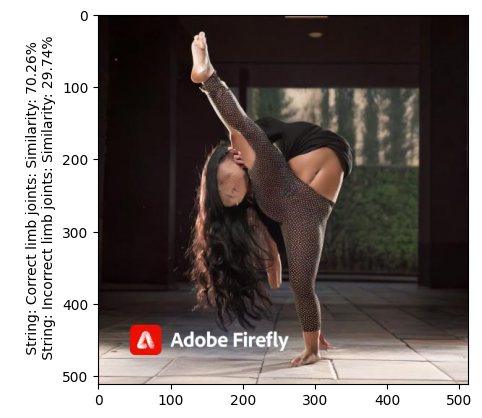


 String: Correct limb joints: Similarity: 70.26%
 String: Incorrect limb joints: Similarity: 29.74%


In [22]:
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# from scrapper import scrape_images

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


def image_text_search(image: Image, text_descriptions: list):
    text = clip.tokenize(text_descriptions).to(device)
    image = preprocess(image).unsqueeze(0).to(device)  # Preprocess the Image

    with torch.no_grad():
        logits_per_image, logits_per_text = model(
            image, text
        )  # Pass both text and Image as Input to the model
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    results = dict(zip(text_descriptions, map(lambda x: x * 100, probs[0])))
    results = {
        k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)
    }  # Sorted Results

    return results


descriptions = ["Correct limb joints", "Incorrect limb joints"]


image = cv2.imread("/kaggle/input/frontflip/Firefly a person doing a front flip 89548 (1).jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
results = image_text_search(image, descriptions)

plt.imshow(np.array(image))
title_string = ""
for key, value in results.items():
    title_string += f"\n String: {key}: Similarity: {value:.2f}%"
plt.ylabel(title_string)
plt.show()
print(title_string)

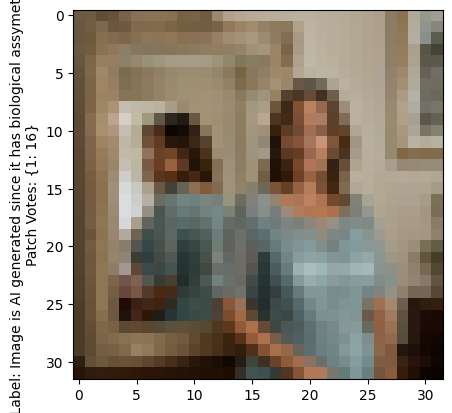

Final Label: Image is AI generated since it has biological assymetry errors
Patch Votes: {1: 16}


In [20]:
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


def image_text_search(image_patches, text_descriptions):
    """
    Compute text-image similarity for each patch and return scores.
    """
    text = clip.tokenize(text_descriptions).to(device)
    patch_results = []

    for patch in image_patches:
        patch = preprocess(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(patch, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        patch_results.append(probs[0])
    
    return np.array(patch_results)  # Shape: (num_patches, num_descriptions)


def split_image_into_patches(image, patch_size):
    """
    Split the image into non-overlapping patches of size (patch_size x patch_size).
    """
    image = np.array(image)
    h, w, c = image.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                patches.append(Image.fromarray(patch))
    return patches


def majority_voting(patch_results, text_descriptions):
    """
    Perform majority voting to determine the most frequent description.
    """
    votes = np.argmax(patch_results, axis=1)  # Get index of max similarity for each patch
    unique, counts = np.unique(votes, return_counts=True)  # Count occurrences
    majority_index = unique[np.argmax(counts)]  # Get the index with the highest count
    return text_descriptions[majority_index], dict(zip(unique, counts))


# Parameters
# descriptions = ["Image is real since it has correct limb joints","Image is AI generated since it has incorrect limb joints", "The image has no limbs"]
patch_size = 32  # Adjust patch size as needed
descriptions = [
    "Image is real since it has no biological assymetry errors",
    "Image is AI generated since it has biological assymetry errors",
    # "The image has no limbs",
]

# Load and preprocess the image
image = cv2.imread("/kaggle/input/random-mirror-lady-fake-lol/Screenshot 2024-11-24 154214.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image = image.resize((256,256))
# Split the image into patches
patches = split_image_into_patches(image, patch_size)

# Compute text-image similarity for each patch
patch_results = image_text_search(patches, descriptions)

# Perform majority voting
final_label, patch_votes = majority_voting(patch_results, descriptions)

# Display the image with results
plt.imshow(np.array(image))
title_string = f"Final Label: {final_label}\nPatch Votes: {patch_votes}"
plt.ylabel(title_string)
plt.show()
print(title_string)


Patch Size: 16, Final Label: Image is AI generated since it has biological assymetry errors, Patch Votes: {0: 34, 1: 222}
Patch Size: 32, Final Label: Image is AI generated since it has biological assymetry errors, Patch Votes: {1: 64}
Patch Size: 64, Final Label: Image is AI generated since it has biological assymetry errors, Patch Votes: {1: 16}
Patch Size: 128, Final Label: Image is AI generated since it has biological assymetry errors, Patch Votes: {1: 4}
Patch Size: 256, Final Label: Image is AI generated since it has biological assymetry errors, Patch Votes: {1: 1}


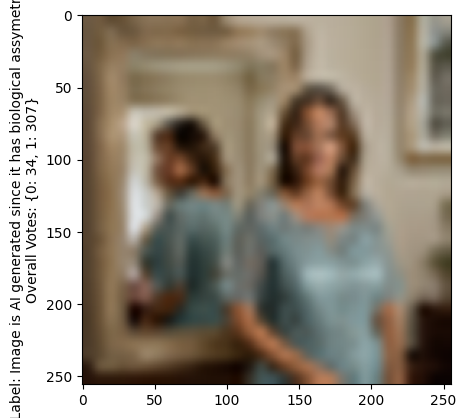

Final Label: Image is AI generated since it has biological assymetry errors
Overall Votes: {0: 34, 1: 307}


In [31]:
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


def image_text_search(image_patches, text_descriptions):
    """
    Compute text-image similarity for each patch and return scores.
    """
    text = clip.tokenize(text_descriptions).to(device)
    patch_results = []

    for patch in image_patches:
        patch = preprocess(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(patch, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        patch_results.append(probs[0])
    
    return np.array(patch_results)  # Shape: (num_patches, num_descriptions)


def split_image_into_patches(image, patch_size):
    """
    Split the image into non-overlapping patches of size (patch_size x patch_size).
    """
    image = np.array(image)
    h, w, c = image.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                patches.append(Image.fromarray(patch))
    return patches


def majority_voting(patch_results, text_descriptions):
    """
    Perform majority voting to determine the most frequent description.
    """
    votes = np.argmax(patch_results, axis=1)  # Get index of max similarity for each patch
    unique, counts = np.unique(votes, return_counts=True)  # Count occurrences
    majority_index = unique[np.argmax(counts)]  # Get the index with the highest count
    return text_descriptions[majority_index], dict(zip(unique, counts))


def overall_majority_vote(results, text_descriptions):
    """
    Perform a majority vote across patch sizes.
    """
    all_votes = np.concatenate([np.argmax(res, axis=1) for res in results])
    unique, counts = np.unique(all_votes, return_counts=True)
    majority_index = unique[np.argmax(counts)]
    return text_descriptions[majority_index], dict(zip(unique, counts))


# Parameters
descriptions = [
    "Image is real since it has no biological assymetry errors",
    "Image is AI generated since it has biological assymetry errors",
    # "The image has no limbs",
]
patch_sizes = [16, 32, 64, 128, 256]  # Patch sizes to process

# Load and preprocess the image
image = cv2.imread("/kaggle/input/random-mirror-lady-fake-lol/Screenshot 2024-11-24 154214.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
# image = image.resize((32, 32)) 
# image = image.resize((256, 256))  # Resize image to a fixed size
# Process the image with each patch size
all_results = []
for patch_size in patch_sizes:
    patches = split_image_into_patches(image, patch_size)
    patch_results = image_text_search(patches, descriptions)
    all_results.append(patch_results)

# Perform majority voting for each patch size
individual_results = []
for i, patch_results in enumerate(all_results):
    label, patch_votes = majority_voting(patch_results, descriptions)
    individual_results.append((patch_sizes[i], label, patch_votes))
    print(f"Patch Size: {patch_sizes[i]}, Final Label: {label}, Patch Votes: {patch_votes}")

# Perform overall majority voting across all patch sizes
final_label, overall_votes = overall_majority_vote(all_results, descriptions)

# Display the image with final results
plt.imshow(np.array(image))
title_string = f"Final Label: {final_label}\nOverall Votes: {overall_votes}"
plt.ylabel(title_string)
plt.show()

print(title_string)


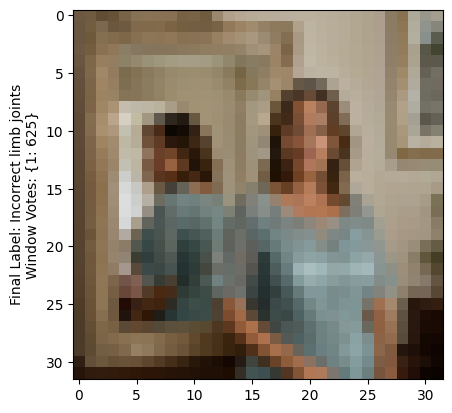

Final Label: Incorrect limb joints
Window Votes: {1: 625}


In [9]:
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


def image_text_search(image_windows, text_descriptions):
    """
    Compute text-image similarity for each sliding window.
    """
    text = clip.tokenize(text_descriptions).to(device)
    window_results = []

    for window in image_windows:
        window = preprocess(window).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(window, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        window_results.append(probs[0])  # Append similarity scores for this window
    
    return np.array(window_results)  # Shape: (num_windows, num_descriptions)


def extract_sliding_windows(image, window_size, stride):
    """
    Extract sliding windows from the image.
    """
    image = np.array(image)
    h, w, c = image.shape
    windows = []
    for y in range(0, h - window_size + 1, stride):
        for x in range(0, w - window_size + 1, stride):
            window = image[y : y + window_size, x : x + window_size]
            windows.append(Image.fromarray(window))
    return windows


def majority_voting(window_results, text_descriptions):
    """
    Perform majority voting to determine the most frequent description.
    """
    votes = np.argmax(window_results, axis=1)  # Get index of max similarity for each window
    unique, counts = np.unique(votes, return_counts=True)  # Count occurrences
    majority_index = unique[np.argmax(counts)]  # Get the index with the highest count
    return text_descriptions[majority_index], dict(zip(unique, counts))


# Parameters
descriptions = ["Correct limb joints", "Incorrect limb joints"]
window_size = 8  # Window size (e.g., 64x64)
stride = 1       # Stride for sliding window

# Load and preprocess the image
image = cv2.imread("/kaggle/input/random-mirror-lady-fake-lol/Screenshot 2024-11-24 154214.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image = image.resize((32,32));

# Extract sliding windows
sliding_windows = extract_sliding_windows(image, window_size, stride)

# Compute text-image similarity for each window
window_results = image_text_search(sliding_windows, descriptions)

# Perform majority voting
final_label, window_votes = majority_voting(window_results, descriptions)

# Display the image with results
plt.imshow(np.array(image))
title_string = f"Final Label: {final_label}\nWindow Votes: {window_votes}"
plt.ylabel(title_string)
plt.show()
print(title_string)


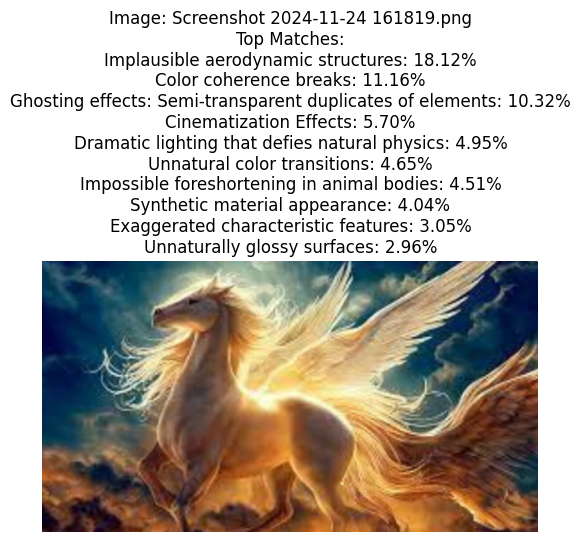

Results saved to image_text_results.json


In [13]:
import os
import json
import clip
import cv2
import numpy as np
import torch
from PIL import Image
from matplotlib import pyplot as plt

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def image_text_search(image: Image, text_descriptions: list):
    """
    Perform image-text similarity search.
    """
    text = clip.tokenize(text_descriptions).to(device)
    image = preprocess(image).unsqueeze(0).to(device)  # Preprocess the Image

    with torch.no_grad():
        logits_per_image, logits_per_text = model(
            image, text
        )  # Pass both text and Image as Input to the model
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    results = dict(zip(text_descriptions, map(lambda x: x * 100, probs[0])))
    results = {
        k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)
    }  # Sorted Results

    return results

def process_image_folder(folder_path, descriptions, output_json_path):
    """
    Process all images in a folder and save the top 5 matches to a JSON file.
    """
    results_dict = {}

    # Iterate through all images in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            # Read and preprocess the image
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = Image.fromarray(image)

            # Perform image-text search
            results = image_text_search(image, descriptions)
            
            # Save the top 5 results
            top_5_results = dict(list(results.items())[:10])  # Get top 5 matches
            results_dict[filename] = top_5_results

            # Optionally visualize
            plt.imshow(np.array(image))
            title_string = "\n".join(
                [f"{key}: {value:.2f}%" for key, value in top_5_results.items()]
            )
            plt.title(f"Image: {filename}\nTop Matches:\n{title_string}")
            plt.axis("off")
            plt.show()

    # Save results to a JSON file
    with open(output_json_path, "w") as f:
        json.dump(results_dict, f, indent=4)

    print(f"Results saved to {output_json_path}")

# Define descriptions and folder paths
descriptions = list(data["Artifact"])  # Replace with your list of text descriptions
folder_path = "/kaggle/input/pegasus"  # Replace with the folder containing images
output_json_path = "image_text_results.json"

# Run the function
process_image_folder(folder_path, descriptions, output_json_path)


Patch Size: 16, Final Label: No creature, Patch Votes: {0: 299, 1: 11, 2: 714}
Patch Size: 32, Final Label: No creature, Patch Votes: {0: 89, 1: 45, 2: 122}
Patch Size: 64, Final Label: No creature, Patch Votes: {0: 20, 1: 21, 2: 23}
Patch Size: 128, Final Label: No creature, Patch Votes: {0: 3, 1: 1, 2: 12}
Patch Size: 256, Final Label: Mythical creature, Patch Votes: {0: 3, 2: 1}


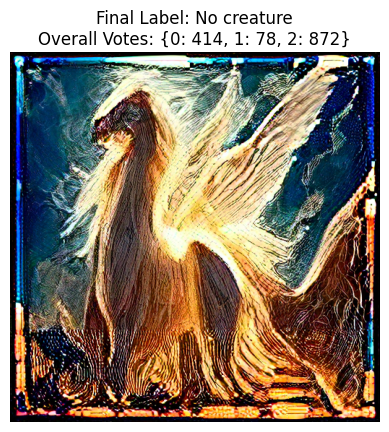

Final Label: No creature
Overall Votes: {0: 414, 1: 78, 2: 872}


In [32]:
import json
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def load_descriptions_from_json(json_path, top_n=10):
    """
    Load top N descriptions from the JSON file.
    """
    with open(json_path, "r") as f:
        data = json.load(f)
    
    # Collect the top N descriptions
    descriptions = []
    for image_name, artifacts in data.items():
        descriptions.extend(list(artifacts.keys())[:top_n])
    
    return list(set(descriptions))  # Deduplicate descriptions


def image_text_search(image_patches, text_descriptions):
    """
    Compute text-image similarity for each patch and return scores.
    """
    text = clip.tokenize(text_descriptions).to(device)
    patch_results = []

    for patch in image_patches:
        patch = preprocess(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(patch, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        patch_results.append(probs[0])
    
    return np.array(patch_results)  # Shape: (num_patches, num_descriptions)


def split_image_into_patches(image, patch_size):
    """
    Split the image into non-overlapping patches of size (patch_size x patch_size).
    """
    image = np.array(image)
    h, w, c = image.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                patches.append(Image.fromarray(patch))
    return patches


def majority_voting(patch_results, text_descriptions):
    """
    Perform majority voting to determine the most frequent description.
    """
    votes = np.argmax(patch_results, axis=1)  # Get index of max similarity for each patch
    unique, counts = np.unique(votes, return_counts=True)  # Count occurrences
    majority_index = unique[np.argmax(counts)]  # Get the index with the highest count
    return text_descriptions[majority_index], dict(zip(unique, counts))


def overall_majority_vote(results, text_descriptions):
    """
    Perform a majority vote across patch sizes.
    """
    all_votes = np.concatenate([np.argmax(res, axis=1) for res in results])
    unique, counts = np.unique(all_votes, return_counts=True)
    majority_index = unique[np.argmax(counts)]
    return text_descriptions[majority_index], dict(zip(unique, counts))


# Load descriptions from the JSON file
json_path = "image_text_results.json"  # Path to the JSON file
# descriptions = load_descriptions_from_json(json_path, top_n=10)
descriptions = ["Mythical creature", "Real animal", "No creature"]

# Parameters
patch_sizes = [16, 32, 64, 128, 256]  # Patch sizes to process

# Load and preprocess the image
image = cv2.imread("/kaggle/working/cropped_image_pegasusarasr.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

# Process the image with each patch size
all_results = []
for patch_size in patch_sizes:
    patches = split_image_into_patches(image, patch_size)
    patch_results = image_text_search(patches, descriptions)
    all_results.append(patch_results)

# Perform majority voting for each patch size
individual_results = []
for i, patch_results in enumerate(all_results):
    label, patch_votes = majority_voting(patch_results, descriptions)
    individual_results.append((patch_sizes[i], label, patch_votes))
    print(f"Patch Size: {patch_sizes[i]}, Final Label: {label}, Patch Votes: {patch_votes}")

# Perform overall majority voting across all patch sizes
final_label, overall_votes = overall_majority_vote(all_results, descriptions)

# Display the image with final results
plt.imshow(np.array(image))
title_string = f"Final Label: {final_label}\nOverall Votes: {overall_votes}"
plt.title(title_string)
plt.axis("off")
plt.show()

print(title_string)


In [ ]:
from PIL import Image

# Open your 192x192 image (replace with your actual image path)
image = Image.open("/kaggle/working/pegasus_aursr.png")
print(image.size)
# Calculate the center coordinates
width, height = image.size
crop_size = 512
left = (width - crop_size) // 2
top = (height - crop_size) // 2
right = (width + crop_size) // 2
bottom = (height + crop_size) // 2

# Crop the image
cropped_image = image.crop((left, top, right, bottom))

# Save or show the cropped image
cropped_image.save("cropped_image_pegasusarasr.png")
cropped_image


Patch Size: 16, Final Label: Unnatural color transitions, Patch Votes: {'Implausible aerodynamic structures': 0, 'Color coherence breaks': 148, 'Ghosting effects: Semi-transparent duplicates of elements': 0, 'Cinematization Effects': 1, 'Dramatic lighting that defies natural physics': 0, 'Unnatural color transitions': 374, 'Impossible foreshortening in animal bodies': 0, 'Synthetic material appearance': 0, 'Exaggerated characteristic features': 303, 'Unnaturally glossy surfaces': 0, 'Not Implausible aerodynamic structures': 0, 'Not Color coherence breaks': 18, 'Not Ghosting effects: Semi-transparent duplicates of elements': 141, 'Not Cinematization Effects': 0, 'Not Dramatic lighting that defies natural physics': 0, 'Not Unnatural color transitions': 38, 'Not Impossible foreshortening in animal bodies': 0, 'Not Synthetic material appearance': 0, 'Not Exaggerated characteristic features': 1, 'Not Unnaturally glossy surfaces': 0}
Patch Size: 32, Final Label: Unnatural color transitions, 

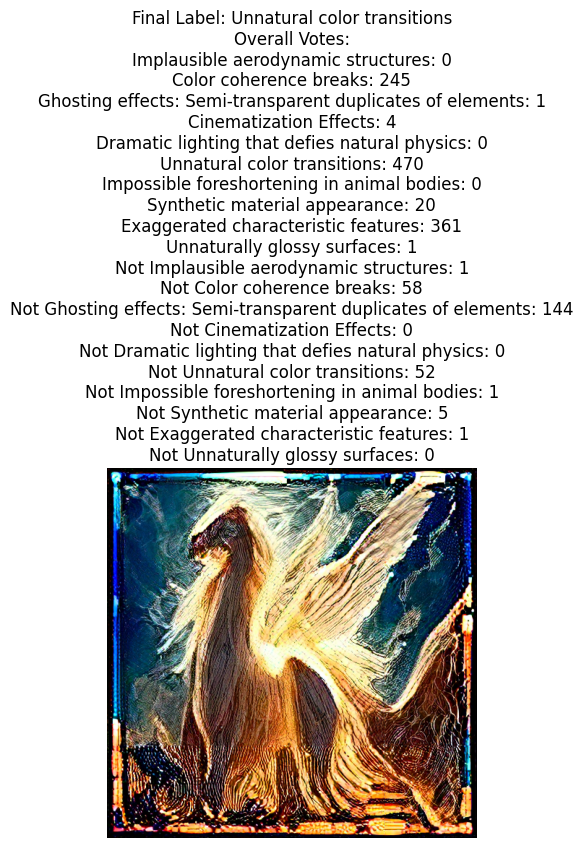

Description Votes:
Implausible aerodynamic structures: 0
Color coherence breaks: 245
Ghosting effects: Semi-transparent duplicates of elements: 1
Cinematization Effects: 4
Dramatic lighting that defies natural physics: 0
Unnatural color transitions: 470
Impossible foreshortening in animal bodies: 0
Synthetic material appearance: 20
Exaggerated characteristic features: 361
Unnaturally glossy surfaces: 1
Not Implausible aerodynamic structures: 1
Not Color coherence breaks: 58
Not Ghosting effects: Semi-transparent duplicates of elements: 144
Not Cinematization Effects: 0
Not Dramatic lighting that defies natural physics: 0
Not Unnatural color transitions: 52
Not Impossible foreshortening in animal bodies: 1
Not Synthetic material appearance: 5
Not Exaggerated characteristic features: 1
Not Unnaturally glossy surfaces: 0


In [30]:
import json
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def create_negations(descriptions):
    """
    Generate negations for each description.
    """
    negated_descriptions = [f"Not {desc}" for desc in descriptions]
    return descriptions + negated_descriptions

def image_text_search(image_patches, text_descriptions):
    """
    Compute text-image similarity for each patch and return scores.
    """
    text = clip.tokenize(text_descriptions).to(device)
    patch_results = []

    for patch in image_patches:
        patch = preprocess(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(patch, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        patch_results.append(probs[0])
    
    return np.array(patch_results)  # Shape: (num_patches, num_descriptions)

def split_image_into_patches(image, patch_size):
    """
    Split the image into non-overlapping patches of size (patch_size x patch_size).
    """
    image = np.array(image)
    h, w, c = image.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                patches.append(Image.fromarray(patch))
    return patches

def majority_voting(patch_results, text_descriptions):
    """
    Perform majority voting to determine the most frequent description.
    """
    votes = np.argmax(patch_results, axis=1)  # Get index of max similarity for each patch
    unique, counts = np.unique(votes, return_counts=True)  # Count occurrences
    vote_dict = dict(zip(unique, counts))
    results = {text_descriptions[i]: vote_dict.get(i, 0) for i in range(len(text_descriptions))}
    majority_index = max(results, key=results.get)
    return majority_index, results

def overall_majority_vote(results, text_descriptions):
    """
    Perform a majority vote across patch sizes.
    """
    all_votes = np.concatenate([np.argmax(res, axis=1) for res in results])
    unique, counts = np.unique(all_votes, return_counts=True)
    vote_dict = dict(zip(unique, counts))
    overall_results = {text_descriptions[i]: vote_dict.get(i, 0) for i in range(len(text_descriptions))}
    majority_index = max(overall_results, key=overall_results.get)
    return majority_index, overall_results

# Load the output JSON from the previous code
output_json_path = "image_text_results.json"  # Replace with your actual path
with open(output_json_path, "r") as f:
    image_text_results = json.load(f)

# Extract top descriptions and add negations
top_descriptions = list(image_text_results.values())[0]  # First image results (adjust if needed)
top_descriptions = list(top_descriptions.keys())[:10]  # Take top 10
descriptions = create_negations(top_descriptions)

# Parameters
patch_sizes = [16, 32, 64, 128, 256]  # Patch sizes to process

# Load and preprocess the image
image = cv2.imread("/kaggle/working/cropped_image_pegasusarasr.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

# Process the image with each patch size
all_results = []
for patch_size in patch_sizes:
    patches = split_image_into_patches(image, patch_size)
    patch_results = image_text_search(patches, descriptions)
    all_results.append(patch_results)

# Perform majority voting for each patch size
individual_results = []
for i, patch_results in enumerate(all_results):
    label, patch_votes = majority_voting(patch_results, descriptions)
    individual_results.append((patch_sizes[i], label, patch_votes))
    print(f"Patch Size: {patch_sizes[i]}, Final Label: {label}, Patch Votes: {patch_votes}")

# Perform overall majority voting across all patch sizes
final_label, overall_votes = overall_majority_vote(all_results, descriptions)

# Display the image with final results
plt.imshow(np.array(image))
title_string = f"Final Label: {final_label}\nOverall Votes:\n" + "\n".join(
    [f"{desc}: {count}" for desc, count in overall_votes.items()]
)
plt.title(title_string)
plt.axis("off")
plt.show()

print("Description Votes:")
for desc, count in overall_votes.items():
    print(f"{desc}: {count}")


In [ ]:
import json
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def create_negations(descriptions):
    """
    Generate negations for each description.
    """
    negated_descriptions = [f"Not {desc}" for desc in descriptions]
    return descriptions + negated_descriptions

def image_text_search(image_patches, text_descriptions):
    """
    Compute text-image similarity for each patch and return scores.
    """
    text = clip.tokenize(text_descriptions).to(device)
    patch_results = []

    for patch in image_patches:
        patch = preprocess(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(patch, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        patch_results.append(probs[0])
    
    return np.array(patch_results)  # Shape: (num_patches, num_descriptions)

def split_image_into_patches(image, patch_size):
    """
    Split the image into non-overlapping patches of size (patch_size x patch_size).
    """
    image = np.array(image)
    h, w, c = image.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                patches.append(Image.fromarray(patch))
    return patches

def calculate_patch_votes(patch_results, text_descriptions):
    """
    Calculate votes for each artifact and its negation for each patch.
    """
    votes = []
    for i, patch_result in enumerate(patch_results):
        patch_votes = {desc: patch_result[j] for j, desc in enumerate(text_descriptions)}
        votes.append(patch_votes)
    return votes

# Load the output JSON from the previous code
output_json_path = "image_text_results.json"  # Replace with your actual path
with open(output_json_path, "r") as f:
    image_text_results = json.load(f)

# Extract top descriptions and add negations
top_descriptions = list(image_text_results.values())[0]  # First image results (adjust if needed)
top_descriptions = list(top_descriptions.keys())[:10]  # Take top 10
descriptions = create_negations(top_descriptions)

# Parameters
patch_size = 64  # Fixed patch size for this example

# Load and preprocess the image
image = cv2.imread("/kaggle/input/random-mirror-lady-fake-lol/Screenshot 2024-11-24 154214.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

# Process the image into patches
patches = split_image_into_patches(image, patch_size)

# Perform text-image search for all patches
patch_results = image_text_search(patches, descriptions)

# Calculate votes for each artifact and its negation
patch_votes = calculate_patch_votes(patch_results, descriptions)

# Tally votes across all patches for each description
tally_votes = {desc: 0 for desc in descriptions}
for vote in patch_votes:
    for desc, prob in vote.items():
        tally_votes[desc] += prob

# Display the image with final results
plt.imshow(np.array(image))
title_string = "Votes:\n" + "\n".join(
    [f"{desc}: {votes:.2f}" for desc, votes in tally_votes.items()]
)
plt.title(title_string)
plt.axis("off")
plt.show()

# Print final results
print("Description Votes:")
for desc, votes in tally_votes.items():
    print(f"{desc}: {votes:.2f}")


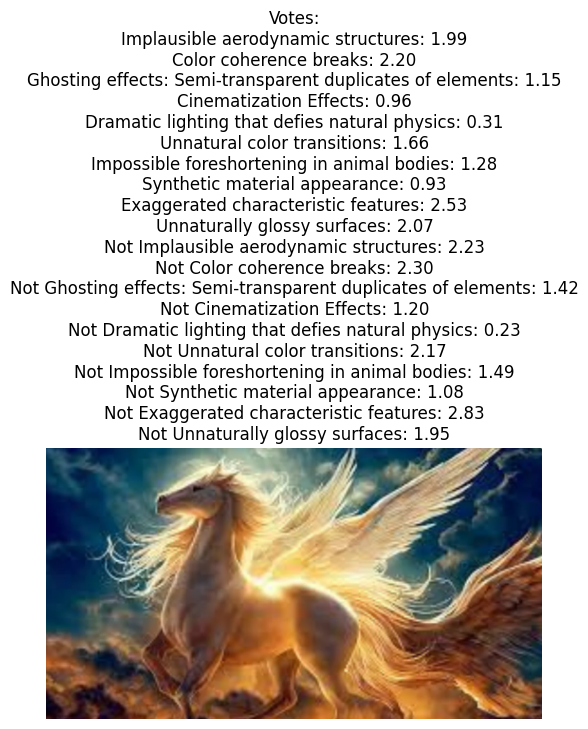

Description Votes:
Implausible aerodynamic structures: 1.99
Color coherence breaks: 2.20
Ghosting effects: Semi-transparent duplicates of elements: 1.15
Cinematization Effects: 0.96
Dramatic lighting that defies natural physics: 0.31
Unnatural color transitions: 1.66
Impossible foreshortening in animal bodies: 1.28
Synthetic material appearance: 0.93
Exaggerated characteristic features: 2.53
Unnaturally glossy surfaces: 2.07
Not Implausible aerodynamic structures: 2.23
Not Color coherence breaks: 2.30
Not Ghosting effects: Semi-transparent duplicates of elements: 1.42
Not Cinematization Effects: 1.20
Not Dramatic lighting that defies natural physics: 0.23
Not Unnatural color transitions: 2.17
Not Impossible foreshortening in animal bodies: 1.49
Not Synthetic material appearance: 1.08
Not Exaggerated characteristic features: 2.83
Not Unnaturally glossy surfaces: 1.95


In [7]:
import json
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def create_negations(descriptions):
    """
    Generate negations for each description.
    """
    negated_descriptions = [f"Not {desc}" for desc in descriptions]
    return descriptions + negated_descriptions

def image_text_search(image_patches, text_descriptions):
    """
    Compute text-image similarity for each patch and return scores.
    """
    text = clip.tokenize(text_descriptions).to(device)
    patch_results = []

    for patch in image_patches:
        patch = preprocess(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(patch, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        patch_results.append(probs[0])
    
    return np.array(patch_results)  # Shape: (num_patches, num_descriptions)

def split_image_into_patches(image, patch_size):
    """
    Split the image into non-overlapping patches of size (patch_size x patch_size).
    """
    image = np.array(image)
    h, w, c = image.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                patches.append(Image.fromarray(patch))
    return patches

def calculate_patch_votes(patch_results, text_descriptions):
    """
    Calculate votes for each artifact and its negation for each patch.
    """
    votes = []
    for i, patch_result in enumerate(patch_results):
        patch_votes = {desc: patch_result[j] for j, desc in enumerate(text_descriptions)}
        votes.append(patch_votes)
    return votes

# Load the output JSON from the previous code
output_json_path = "image_text_results.json"  # Replace with your actual path
with open(output_json_path, "r") as f:
    image_text_results = json.load(f)

# Extract top descriptions and add negations
top_descriptions = list(image_text_results.values())[0]  # First image results (adjust if needed)
top_descriptions = list(top_descriptions.keys())[:10]  # Take top 10
descriptions = create_negations(top_descriptions)

# Parameters
patch_size = 64  # Fixed patch size for this example

# Load and preprocess the image
image = cv2.imread("/kaggle/input/pegasus/Screenshot 2024-11-24 161819.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)

# Process the image into patches
patches = split_image_into_patches(image, patch_size)

# Perform text-image search for all patches
patch_results = image_text_search(patches, descriptions)

# Calculate votes for each artifact and its negation
patch_votes = calculate_patch_votes(patch_results, descriptions)

# Tally votes across all patches for each description
tally_votes = {desc: 0 for desc in descriptions}
for vote in patch_votes:
    for desc, prob in vote.items():
        tally_votes[desc] += prob

# Display the image with final results
plt.imshow(np.array(image))
title_string = "Votes:\n" + "\n".join(
    [f"{desc}: {votes:.2f}" for desc, votes in tally_votes.items()]
)
plt.title(title_string)
plt.axis("off")
plt.show()

# Print final results
print("Description Votes:")
for desc, votes in tally_votes.items():
    print(f"{desc}: {votes:.2f}")


(48, 48)
(768, 768)


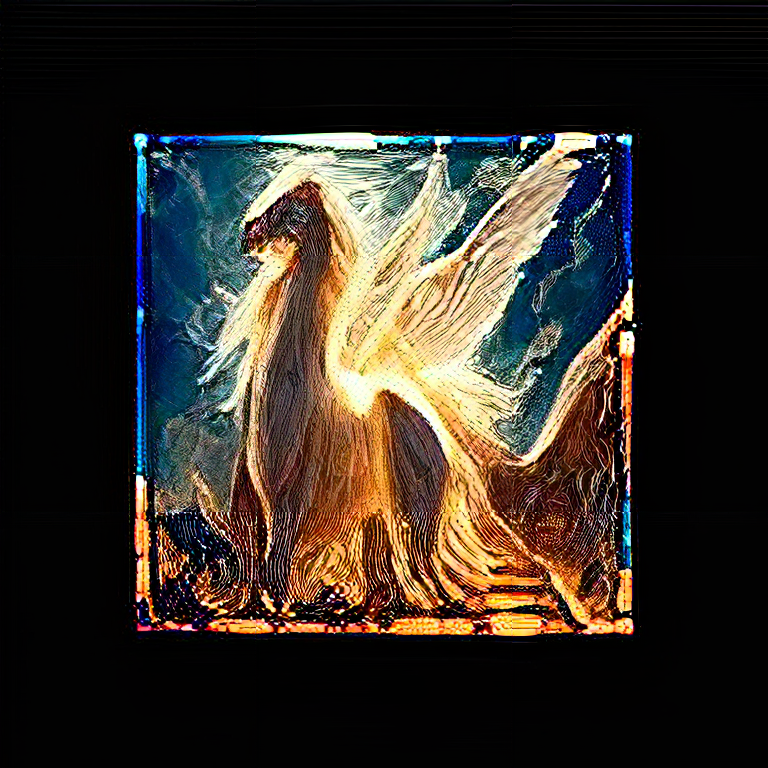

In [64]:
from PIL import Image
# from PIL import Image
import cv2
image = cv2.imread("/kaggle/input/pegasus/Screenshot 2024-11-24 161819.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
# img = Image("/kaggle/input/pegasus/Screenshot 2024-11-24 161819.png")
image = image.resize((32,32))
image.save("/kaggle/working/testgradcam/test/FAKE/peg32.png")
image.save("/kaggle/working/testgradcam/test/REAL/peg32.png")

image.save("/kaggle/working/testgradcam/train/FAKE/peg32.png")
image.save("/kaggle/working/testgradcam/train/REAL/peg32.png")

# Load your 32x32 image (replace with your image path)
# image = Image.new("RGB", (32, 32), color="red")  # Example red image

# Calculate padding
pad_size = (48 - 32) // 2  # 8 pixels on each side

# Add padding
padded_image = Image.new("RGB", (48, 48), color=(0, 0, 0))  # Black padding
padded_image.paste(image, (pad_size, pad_size))  # Paste the original image centered

# Show the padded image
print(padded_image.size)
# import matplotlib.pyplot as plt
# for i in range(len(cifar10)):
#   img, label = cifar10[i]
upscaled_image = aura_sr.upscale_4x(padded_image)
upscaled_image = aura_sr.upscale_4x(upscaled_image)
# upscaled_image = cv2.resize(np.array(upscaled_image), (32,32), interpolation=cv2.INTER_CUBIC)
# cv2.imwrite("pegasus_aursr.png", upscaled_image)
# Image.save("pegasus_aursr", upscaled_image)
upscaled_image.save("pegasus_aursr.png")
print(upscaled_image.size)
upscaled_image
  # if i%100 == 0:
  #   print(i)


In [66]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import cv2
from tqdm import tqdm
import os
def generate_intensity_matrix(grayscale_cam, size=(32, 32)):
    # Resize the grayscale CAM to desired dimensions
    intensity_matrix = cv2.resize(grayscale_cam, size, interpolation=cv2.INTER_LINEAR)
    # Values are already normalized between 0 and 1 from GradCAM
    return intensity_matrix

def generate_gradcam_visualizations(
    model_path,
    dataset_path,
    output_dir,
    num_samples=1,  # Changed to 1 for testing
    device='cuda'
):
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Load model
    model = load_model(model_path, device)

    # Define target layer for GradCAM
    target_layers = [model.layer4[-1]]
    # Initialize GradCAM
    cam = GradCAM(
        model=model,
        target_layers=target_layers,
    )

    # Setup data loading
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    # Load dataset
    dataset = torchvision.datasets.ImageFolder(
        root=dataset_path,
        transform=transform
    )

    # Select random samples
    num_samples = min(num_samples, len(dataset))
    indices = torch.randperm(len(dataset))[:num_samples]

    # Process each image
    for idx in tqdm(indices, desc="Generating Grad-CAM visualizations"):
        # Get image and label
        img_tensor, label = dataset[idx]
        input_tensor = img_tensor.unsqueeze(0)

        # Get original image for overlay
        img_path = dataset.imgs[idx][0]
        rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
        rgb_img = cv2.resize(rgb_img, (224, 224))
        rgb_img = np.float32(rgb_img) / 255

        # Generate class activation map
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        # Generate 32x32 intensity matrix
        intensity_matrix = generate_intensity_matrix(grayscale_cam)

        # Save intensity matrix
        matrix_output_path = os.path.join(
            output_dir,
            f"intensity_matrix_{idx}.npy"
        )
        np.save(matrix_output_path, intensity_matrix)

        # Print shape and some statistics of the intensity matrix
        print(f"Intensity Matrix Shape: {intensity_matrix.shape}")
        print(f"Min value: {intensity_matrix.min():.4f}")
        print(f"Max value: {intensity_matrix.max():.4f}")
        print(f"Mean value: {intensity_matrix.mean():.4f}")

        # Overlay CAM on original image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        # Get model prediction
        with torch.no_grad():
            output = model(input_tensor.to(device))
            pred = output.argmax(dim=1).item()

        # Save the visualization
        output_path = os.path.join(
            output_dir,
            f"gradcam_{idx}_pred{pred}_true{label}.jpg"
        )
        cv2.imwrite(output_path, visualization[:, :, ::-1])

In [67]:
generate_gradcam_visualizations(
        model_path='/kaggle/input/forgradcam/pytorch/default/1/fake_detector.pth',
        dataset_path='/kaggle/working/testgradcam',
        output_dir='gradcam_visualizations',
        num_samples=1,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

/tmp/ipykernel_30/1497713901.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Generating Grad-CAM visualizations: 100%|████

Intensity Matrix Shape: (32, 32)
Min value: 0.0000
Max value: 0.9721
Mean value: 0.2155


In [122]:
import json
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

def load_descriptions_from_json(json_path, top_n=10):
    """
    Load top N descriptions from the JSON file.
    """
    with open(json_path, "r") as f:
        data = json.load(f)
    
    # Collect the top N descriptions
    descriptions = []
    for image_name, artifacts in data.items():
        descriptions.extend(list(artifacts.keys())[:top_n])
    
    return list(set(descriptions))  # Deduplicate descriptions


def image_text_search(image_patches, text_descriptions):
    """
    Compute text-image similarity for each patch and return scores.
    """
    text = clip.tokenize(text_descriptions).to(device)
    patch_results = []

    for patch in image_patches:
        patch = preprocess(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(patch, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        patch_results.append(probs[0])
    
    return np.array(patch_results)  # Shape: (num_patches, num_descriptions)


def split_image_into_patches(image, patch_size, intensities):
    """
    Split the image into non-overlapping patches of size (patch_size x patch_size).
    """
    image = np.array(image)
    h, w, c = image.shape
    patches = []
    intensity = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = image[i : i + patch_size, j : j + patch_size]
            gradpatch = intensities[i : i + patch_size, j : j + patch_size]
            if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                patches.append(Image.fromarray(patch))
                intensity.append(np.sum(gradpatch))
    return patches, intensity

# def patch_weight(i, j, image, intensity)


def give_result(patch_results, text_descriptions, patch_weights):
    """
    Perform majority voting to determine the most frequent description.
    """
    votes = np.argmax(patch_results, axis=1)  # Get index of max similarity for each patch
    weighted_avg = (votes==0)*patch_weights / ((votes!=2)*patch_weights)
    # unique, counts = np.unique(votes, return_counts=True)  # Count occurrences
    # majority_index = unique[np.argmax(counts)]  # Get the index with the highest count
    return weighted_avg


def overall_majority_vote(results, text_descriptions):
    """
    Perform a majority vote across patch sizes.
    """
    all_votes = np.concatenate([np.argmax(res, axis=1) for res in results])
    unique, counts = np.unique(all_votes, return_counts=True)
    majority_index = unique[np.argmax(counts)]
    return text_descriptions[majority_index], dict(zip(unique, counts))


# Load descriptions from the JSON file
json_path = "image_text_results.json"  # Path to the JSON file
# descriptions = load_descriptions_from_json(json_path, top_n=10)
descriptions = ["Unaligned wheels", "Proper wheels", "No wheels"]

# Parameters
patch_sizes = [16, 32, 64, 128, 256]  # Patch sizes to process

# Load and preprocess the image
image = cv2.imread("/kaggle/working/cropped_image_pegasusarasr.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
intensity = np.load("/kaggle/working/gradcam_visualizations/intensity_matrix_3.npy")
intensity = np.array(Image.fromarray(intensity).resize((512,512)))
# Process the image with each patch size
all_results = []
all_weights = []
for patch_size in patch_sizes:
    patches, patch_intensity = split_image_into_patches(image, patch_size, intensity)
    patch_results = image_text_search(patches, descriptions)
    all_results.append(list(patch_results))
    all_weights.append(patch_intensity)

# all_results[0].shape

# allnp.array([i for j in all_results for i in j])
# # Perform majority voting for each patch size
# individual_results = []

stacked_results = np.array([i for j in all_results for i in j])
stacked_weights = np.array([i for j in all_weights for i in j])



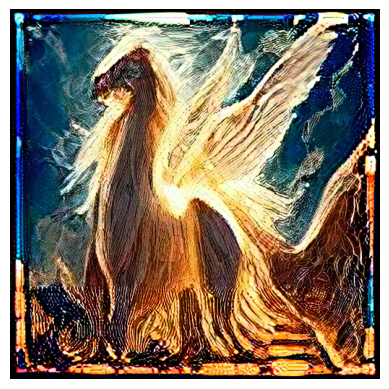

1.0


In [123]:
def give_result(patch_results, text_descriptions, patch_weights):
    """
    Perform majority voting to determine the most frequent description.
    """
    votes = np.argmax(patch_results, axis=1)  # Get index of max similarity for each patch
    weighted_avg = np.sum((votes==0)*patch_weights) / np.sum((votes!=2)*patch_weights)
    # unique, counts = np.unique(votes, return_counts=True)  # Count occurrences
    # majority_index = unique[np.argmax(counts)]  # Get the index with the highest count
    return weighted_avg
# # for i, patch_results in enumerate(all_results):
weighted_avg = give_result(stacked_results, descriptions, stacked_weights)
#     # individual_results.append((patch_sizes[i], label, patch_votes))
#     # print(f"Patch Size: {patch_sizes[i]}, Final Label: {label}, Patch Votes: {patch_votes}")

# # Perform overall majority voting across all patch sizes
# # final_label, overall_votes = overall_majority_vote(all_results, descriptions)

# Display the image with final results
plt.imshow(np.array(image))
# title_string = f"Final Label: {final_label}\nOverall Votes: {overall_votes}"
# plt.title(title_string)
plt.axis("off")
plt.show()

print(weighted_avg)

In [81]:
np.array([i for j in all_results for i in j]).shape

(1364, 3)

In [82]:
np.array([i for j in all_weights for i in j]).shape

(1364,)

In [104]:
votes = np.argmax(stacked_results, axis=1)
np.sum((votes==0))

921

In [107]:
image.size

(512, 512)

In [111]:
for i in range(0, 512, 16):
        for j in range(0, 512, 16):
            # patch = image[i : i + patch_size, j : j + patch_size]
            gradpatch = intensity[i : i + patch_size, j : j + patch_size]
            # if patch.shape[:2] == (patch_size, patch_size):  # Ensure patch size
                # patches.append(Image.fromarray(patch))
                # intensity.append(np.sum(gradpatch))

In [112]:
gradpatch

array([], shape=(0, 0), dtype=float32)